# Fashion category classification 
- Examples using Fashion-MNIST database in Keras

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Activation, BatchNormalization
from keras import optimizers

## Load Dataset
- Fashion-MNIST dataset in Keras
- doc: https://keras.io/datasets/

In [16]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


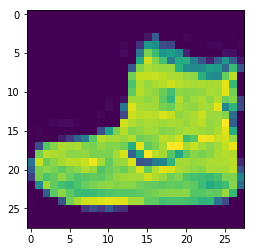

Label:  9


In [7]:
plt.imshow(X_train[0])
plt.show()
print('Label: ', y_train[0])

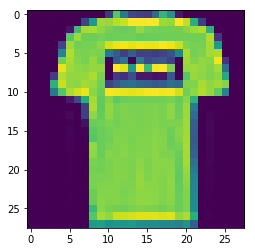

Label:  0


In [8]:
plt.imshow(X_train[1])
plt.show()
print('Label: ', y_train[1])

## 1. Simple MLP
- Naive MLP classification

In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [22]:
def simple_mlp():
    inputs = Input(shape = (X_train.shape[1],))
    l = Dense(100, kernel_initializer = 'he_normal')(inputs)
    l = Activation('selu')(l)
    l = BatchNormalization()(l)
    l = Dense(100, kernel_initializer = 'he_normal')(l)
    l = Activation('selu')(l)
    l = BatchNormalization()(l)
    outputs = Dense(10, activation = 'softmax')(l)
    
    adam = optimizers.adam(lr = 0.001)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [26]:
model = simple_mlp()

In [29]:
%%time
history = model.fit(X_train, y_train, epochs = 100, batch_size = 200, validation_split = 0.3, verbose = 0)

Wall time: 2min 14s


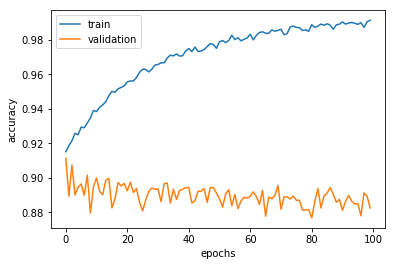

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
results = model.evaluate(X_test, y_test)

 9824/10000 [============================>.] - ETA: 0s

In [33]:
print('Test accuracy: ', results[1])

Test accuracy:  0.8694


## 2. Reduced Dimension MLP
- Reduce the dimensionality of the training data by autoencoder, and then classify using MLP

In [34]:
def auto_encoder_model(code_dim):    
    inputs = Input(shape = (X_train.shape[1],), name = 'input')                         # input layer
    code = Dense(code_dim, activation = 'relu', name = 'code')(inputs)                  # hidden layer => represents "codes"
    outputs = Dense(X_train.shape[1], activation = 'softmax', name = 'output')(code)    # output layer

    auto_encoder = Model(inputs = inputs, outputs = outputs)

    encoder = Model(inputs = inputs, outputs = code)

    decoder_input = Input(shape = (code_dim,))
    decoder_output = auto_encoder.layers[-1]
    decoder = Model(inputs = decoder_input, outputs = decoder_output(decoder_input))

    auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, decoder, auto_encoder

In [36]:
%%time
encoder, decoder, auto_encoder = auto_encoder_model(100)
auto_encoder.fit(X_train, X_train, epochs = 100, batch_size = 100, validation_data = (X_test, X_test), verbose = 0)

Wall time: 6min 32s


In [37]:
X_train_re = encoder.predict(X_train)
X_test_re = encoder.predict(X_test)

In [38]:
def dim_reduced_mlp():
    inputs = Input(shape = (X_train_re.shape[1],))
    l = Dense(100, kernel_initializer = 'he_normal')(inputs)
    l = Activation('selu')(l)
    l = BatchNormalization()(l)
    l = Dense(100, kernel_initializer = 'he_normal')(l)
    l = Activation('selu')(l)
    l = BatchNormalization()(l)
    outputs = Dense(10, activation = 'softmax')(l)
    
    adam = optimizers.adam(lr = 0.001)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [39]:
model = dim_reduced_mlp()

In [40]:
%%time
history = model.fit(X_train_re, y_train, epochs = 100, batch_size = 200, validation_split = 0.3, verbose = 0)

Wall time: 2min 6s


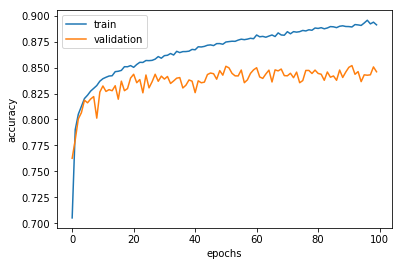

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
results = model.evaluate(X_test_re, y_test)

 9600/10000 [===========================>..] - ETA: 0s

In [43]:
print('Test accuracy: ', results[1])

Test accuracy:  0.8352
